In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv


In [75]:
sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')


Helper functions

In [76]:
## Function to reduce the DF size from https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Loading the data and merging id and transaction data sets

In [77]:
train_transaction_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

test_transaction_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

df_train = train_transaction_df.merge(train_identity_df, how='left', left_index=True, right_index=True, on='TransactionID')
df_test = test_transaction_df.merge(test_identity_df, how='left', left_index=True, right_index=True, on='TransactionID')

del train_transaction_df, train_identity_df, test_transaction_df, test_identity_df

Reducing memory usage (from https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)

In [78]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


## Feature Engineering

Binning e-mail addresses

In [79]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

Creating feature aggregations (from https://www.kaggle.com/artgor/eda-and-models)

In [80]:
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

df_train['id_02_to_mean_card1'] = df_train['id_02'] / df_train.groupby(['card1'])['id_02'].transform('mean')
df_train['id_02_to_mean_card4'] = df_train['id_02'] / df_train.groupby(['card4'])['id_02'].transform('mean')
df_train['id_02_to_std_card1'] = df_train['id_02'] / df_train.groupby(['card1'])['id_02'].transform('std')
df_train['id_02_to_std_card4'] = df_train['id_02'] / df_train.groupby(['card4'])['id_02'].transform('std')

df_test['id_02_to_mean_card1'] = df_test['id_02'] / df_test.groupby(['card1'])['id_02'].transform('mean')
df_test['id_02_to_mean_card4'] = df_test['id_02'] / df_test.groupby(['card4'])['id_02'].transform('mean')
df_test['id_02_to_std_card1'] = df_test['id_02'] / df_test.groupby(['card1'])['id_02'].transform('std')
df_test['id_02_to_std_card4'] = df_test['id_02'] / df_test.groupby(['card4'])['id_02'].transform('std')

df_train['D15_to_mean_card1'] = df_train['D15'] / df_train.groupby(['card1'])['D15'].transform('mean')
df_train['D15_to_mean_card4'] = df_train['D15'] / df_train.groupby(['card4'])['D15'].transform('mean')
df_train['D15_to_std_card1'] = df_train['D15'] / df_train.groupby(['card1'])['D15'].transform('std')
df_train['D15_to_std_card4'] = df_train['D15'] / df_train.groupby(['card4'])['D15'].transform('std')

df_test['D15_to_mean_card1'] = df_test['D15'] / df_test.groupby(['card1'])['D15'].transform('mean')
df_test['D15_to_mean_card4'] = df_test['D15'] / df_test.groupby(['card4'])['D15'].transform('mean')
df_test['D15_to_std_card1'] = df_test['D15'] / df_test.groupby(['card1'])['D15'].transform('std')
df_test['D15_to_std_card4'] = df_test['D15'] / df_test.groupby(['card4'])['D15'].transform('std')

df_train['D15_to_mean_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('mean')
df_train['D15_to_mean_addr2'] = df_train['D15'] / df_train.groupby(['addr2'])['D15'].transform('mean')
df_train['D15_to_std_addr1'] = df_train['D15'] / df_train.groupby(['addr1'])['D15'].transform('std')
df_train['D15_to_std_addr2'] = df_train['D15'] / df_train.groupby(['addr2'])['D15'].transform('std')

df_test['D15_to_mean_addr1'] = df_test['D15'] / df_test.groupby(['addr1'])['D15'].transform('mean')
df_test['D15_to_mean_addr2'] = df_test['D15'] / df_test.groupby(['addr2'])['D15'].transform('mean')
df_test['D15_to_std_addr1'] = df_test['D15'] / df_test.groupby(['addr1'])['D15'].transform('std')
df_test['D15_to_std_addr2'] = df_test['D15'] / df_test.groupby(['addr2'])['D15'].transform('std')



Log transforming TransactionAmt

In [81]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

Adding the decimals of TransactionAmt as a feature

In [82]:
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

Adding day of the week and hour of the day as features

In [83]:
# New feature - day of week in which a transaction happened.
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

Label encoding for categorical features

In [88]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  

Fill missing values to avoid overfitting

In [89]:
for col in df_train.columns:
    df_train[col].fillna(-999, inplace=True)
    
for col in df_test.columns:
    df_test[col].fillna(-999, inplace=True)

Dropping TransactionID as a feature

In [90]:
df_train.drop(['TransactionID'], axis=1)
df_test.drop(['TransactionID'], axis=1)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_mean_addr2,D15_to_std_addr1,D15_to_std_addr2,TransactionAmt_decimal,Transaction_day_of_week,Transaction_hour
0,18403224,3.464844,4,10409,111.0,150.0,4,226.0,2,170.0,...,1.925781,1.666016,0.0,1.557617,1.759766,0.0,0.0,464,2.0,0.0
1,18403263,3.892578,4,4272,111.0,150.0,4,226.0,2,299.0,...,2.984375,0.000000,0.0,3.033203,2.728516,0.0,0.0,892,2.0,0.0
2,18403310,5.140625,4,4476,574.0,150.0,4,226.0,2,472.0,...,0.456787,0.000000,0.0,0.457031,0.417480,0.0,0.0,140,2.0,0.0
3,18403310,5.652344,4,10989,360.0,150.0,4,166.0,2,205.0,...,1.139648,1.129883,0.0,1.020508,1.041016,0.0,0.0,652,2.0,0.0
4,18403317,4.218750,4,18018,452.0,150.0,2,117.0,2,264.0,...,0.109680,0.000000,0.0,0.098999,0.094666,0.0,0.0,218,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,4.550781,0,13832,375.0,185.0,2,224.0,2,284.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,550,2.0,23.0
506687,34214287,2.500000,0,3154,408.0,185.0,2,224.0,2,-999.0,...,0.079773,0.104919,0.0,-999.000000,-999.000000,-999.0,-999.0,500,2.0,23.0
506688,34214326,3.892578,4,16661,490.0,150.0,4,226.0,2,327.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,892,2.0,23.0
506689,34214337,5.308594,4,16621,516.0,150.0,2,224.0,2,177.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,308,2.0,23.0


## Model Training and Prediction (LGB)

In [91]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


In [92]:
X = df_train.drop(['isFraud'], axis=1)
y = df_train['isFraud']
X_test = df_test

Best params from https://www.kaggle.com/nroman/lgb-single-model-lb-0-9419

In [98]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

CV code adapted from https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm/notebook

In [99]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=150)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score.append(roc_auc_score(y_valid, y_pred_valid))
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print("\nMean AUC = {}".format(sum(score) / NFOLDS))
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print("\nAUC Standard Deviation = {}".format(np.std(score)))

Training until validation scores don't improve for 150 rounds.
[200]	training's auc: 0.949792	valid_1's auc: 0.884081
[400]	training's auc: 0.971203	valid_1's auc: 0.898278
[600]	training's auc: 0.985576	valid_1's auc: 0.908553
[800]	training's auc: 0.992474	valid_1's auc: 0.914282
[1000]	training's auc: 0.995863	valid_1's auc: 0.917413
[1200]	training's auc: 0.99769	valid_1's auc: 0.919282
[1400]	training's auc: 0.998621	valid_1's auc: 0.920102
[1600]	training's auc: 0.999173	valid_1's auc: 0.920214
[1800]	training's auc: 0.999517	valid_1's auc: 0.920141
Early stopping, best iteration is:
[1716]	training's auc: 0.999391	valid_1's auc: 0.920295
Fold 1 | AUC: 0.9202946145181783
Training until validation scores don't improve for 150 rounds.
[200]	training's auc: 0.950209	valid_1's auc: 0.908555
[400]	training's auc: 0.971895	valid_1's auc: 0.919617
[600]	training's auc: 0.986497	valid_1's auc: 0.928775
[800]	training's auc: 0.993505	valid_1's auc: 0.933587
[1000]	training's auc: 0.996752

Submission

In [100]:
sample_submission['isFraud'] = y_preds
sample_submission.to_csv('LGBM_model_1.csv', index=False)

Visualizing feature importance

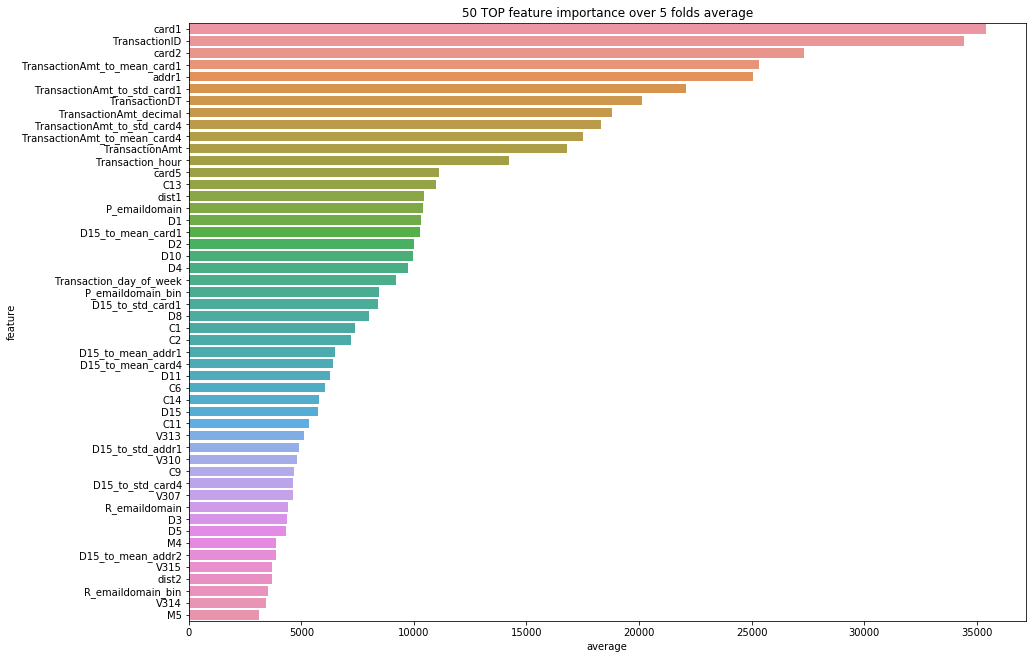

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(15,11))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));